# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
sys.path.append("../src")
from dataframe_analyzer import DataFrameAnalyzer
from plot_utils import DataVisualizer
#from pipeline_first_approach import FraudDetectionModel
from pipeline import FraudDetectionModel
import mlflow.sklearn
import shap




pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Load Data

In [3]:
data = pd.read_csv(r"/mnt/d/fraud_detection_test/data/fraud_detection.csv")
df=data.copy()

# Question 1: To find the most relevant variables for the classification of movements into fraudulent and non-fraudulent

## Mini Exploratory Data Analysis - EDA

In [4]:
df.shape

(6362620, 11)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [24]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
step,6362620.00,243.40,142.33,1.00,156.00,239.00,335.00,743.00
amount,6362620.00,179861.90,603858.23,0.00,13389.57,74871.94,208721.48,92445516.64
oldbalanceOrg,6362620.00,833883.10,2888242.67,0.00,0.00,14208.00,107315.18,59585040.37
newbalanceOrig,6362620.00,855113.67,2924048.50,0.00,0.00,0.00,144258.41,49585040.37
oldbalanceDest,6362620.00,1100701.67,3399180.11,0.00,0.00,132705.66,943036.71,356015889.35
newbalanceDest,6362620.00,1224996.40,3674128.94,0.00,0.00,214661.44,1111909.25,356179278.92
isFraud,6362620.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [41]:
# DISCLAIMER: La variable “isFlaggedFraud” creo que es un error por dos razones: No la mencionan en el .txt que explica
# las variables y es contraintuitiva respecto a “isFraud”
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [42]:
# df = df.drop('isFlaggedFraud', axis=1)

In [78]:
# TODO: En la sección de visualización mostrar gráficamente cómo se podría mejorar este sesgo.
# TODO: Lo importante es tenerlo en mente al momento de modelar.

skew =df.select_dtypes(include=['number']).skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_df.head(10)

,skew
isFlaggedFraud,630.60
amount,30.99
isFraud,27.78
oldbalanceDest,19.92
newbalanceDest,19.35
oldbalanceOrg,5.25
newbalanceOrig,5.18
step,0.38


In [79]:
pd.DataFrame(df.select_dtypes(include=['number']).kurtosis().sort_values(ascending =False ),columns=['Kurtosis'])

,Kurtosis
isFlaggedFraud,397659.06
amount,1797.96
oldbalanceDest,948.67
newbalanceDest,862.16
isFraud,769.70
oldbalanceOrg,32.96
newbalanceOrig,32.07
step,0.33


In [43]:
# REMINDER: La varianza del target es muy baja "isFraud". Claramente por el desbalance entre las clases...
pd.DataFrame(df.select_dtypes(include=['number']).var().sort_values(ascending =False ),columns=['Variance'])

,Variance
newbalanceDest,13499223483321.15
oldbalanceDest,11554425440577.14
newbalanceOrig,8550059647629.09
oldbalanceOrg,8341945738355.12
amount,364644763705.54
step,20258.39
isFraud,0.00
isFlaggedFraud,0.00


In [ ]:
df.describe(include=[object]).T

,count,unique,top,freq
type,6362620,5,CASH_OUT,2237500
nameOrig,6362620,6353307,C1902386530,3
nameDest,6362620,2722362,C1286084959,113


In [ ]:
# Solo para verificar si este cliente que fue el que más transacciones REALIZÓ era fraudulento.
df[df['nameOrig'] == 'C1902386530']

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1165338,132,CASH_OUT,487055.28,C1902386530,0.00,0.00,C807210147,2497616.59,2984671.87,0,0
2300990,188,TRANSFER,29700.56,C1902386530,43077.00,13376.44,C1419531968,149417.09,179117.65,0,0
5761952,400,CASH_OUT,246956.95,C1902386530,0.00,0.00,C1278669763,1680085.52,1927042.47,0,0


In [ ]:
# # Solo para verificar si este cliente que fue el que más transacciones RECIBIÓ era fraudulento.
df[df['nameDest'] == 'C1286084959']

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
93,1,TRANSFER,583848.46,C1839168128,0.00,0.00,C1286084959,667778.00,2107778.11,0,0
367,1,TRANSFER,176334.26,C169880779,45136.00,0.00,C1286084959,1251626.46,2107778.11,0,0
388,1,CASH_OUT,373068.26,C1047934137,20034.00,0.00,C1286084959,1427960.73,2107778.11,0,0
471,1,CASH_IN,403418.39,C848097505,3834666.95,4238085.34,C1286084959,1801028.99,2107778.11,0,0
642,1,CASH_IN,222126.95,C870322840,6688712.64,6910839.59,C1286084959,1397610.60,2107778.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4810092,346,CASH_OUT,84205.39,C86576996,0.00,0.00,C1286084959,61680519.75,61764725.14,0,0
4832993,347,CASH_OUT,235564.75,C1068656420,0.00,0.00,C1286084959,61764725.14,62000289.89,0,0
5566959,393,CASH_IN,119568.31,C1878371174,8348248.96,8467817.28,C1286084959,62000289.89,61880721.58,0,0
5596560,394,CASH_OUT,381887.53,C1789981744,50447.00,0.00,C1286084959,61880721.58,62262609.11,0,0


In [ ]:
analyzer = DataFrameAnalyzer(df)
nan_analysis_result = analyzer.nan_values_analysis(save_to_excel=False)
nan_analysis_result.head(12)

,Variable,Null Values,Null Values Percentage (%),Min Value,Max Value,Data Type
0,step,0,0.00,1.00,743.00,int64
1,type,0,0.00,NaN,NaN,object
2,amount,0,0.00,0.00,92445516.64,float64
3,nameOrig,0,0.00,NaN,NaN,object
4,oldbalanceOrg,0,0.00,0.00,59585040.37,float64
5,newbalanceOrig,0,0.00,0.00,49585040.37,float64
6,nameDest,0,0.00,NaN,NaN,object
7,oldbalanceDest,0,0.00,0.00,356015889.35,float64
8,newbalanceDest,0,0.00,0.00,356179278.92,float64
9,isFraud,0,0.00,0.00,1.00,int64


In [ ]:
fraud_counts = df['isFraud'].value_counts()

print(fraud_counts)

print(f"Porcentaje de 'isFraud'= 1: {(fraud_counts[1] / fraud_counts.sum()) * 100:.2f}%")

isFraud
0    6354407
1       8213
Name: count, dtype: int64
Porcentaje de 'isFraud' = 1: 0.13%


The data shows that only 0.13% of transactions are fraudulent, pointing out that fraud is rare but important to catch. This small percentage makes it hard for machine learning algorithms to predict fraud accurately because they tend to overlook such rare occurrences without extra steps to balance the data.

### Some Plots - Visual Analysis

In [50]:
visualizer = DataVisualizer(df)

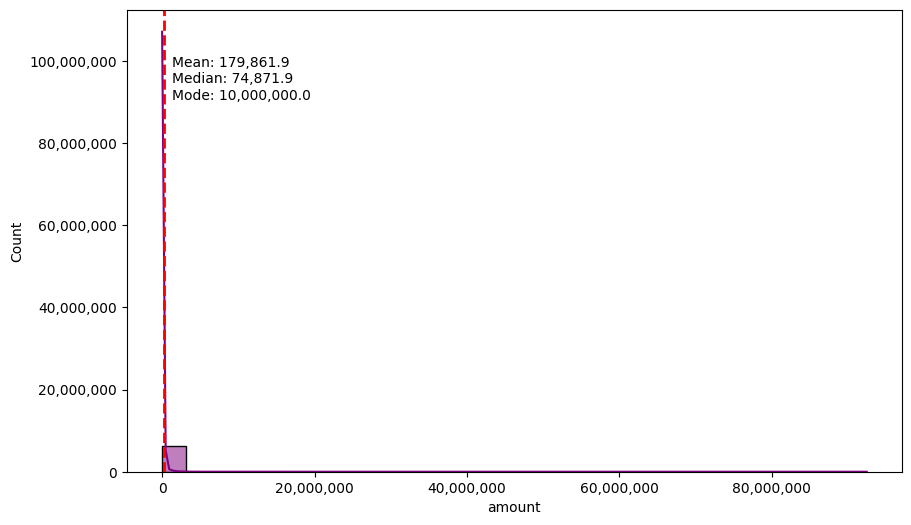

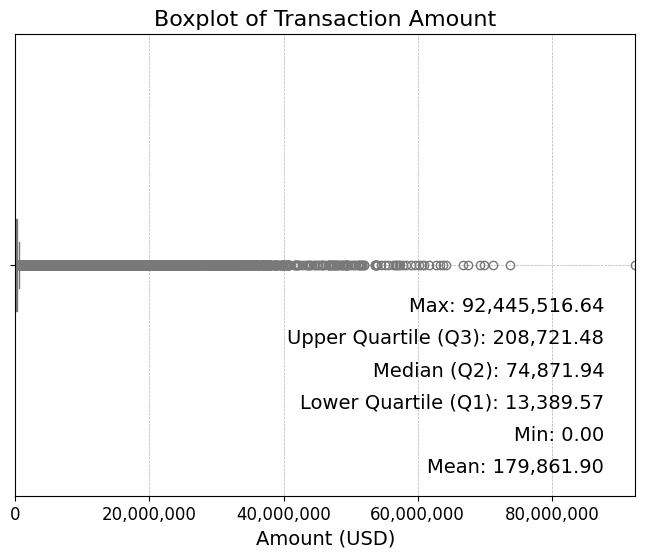

Variable: amount
Count of outliers: 338078
Percentage of outliers: 5.31%
Lower bound for outliers: -279608.29
Upper bound for outliers: 501719.34


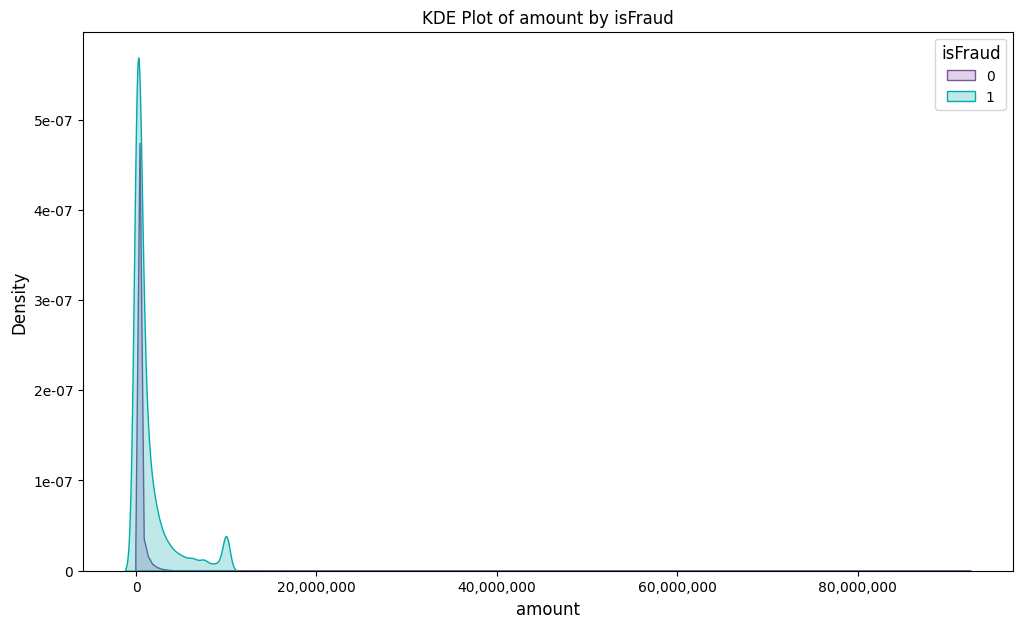

The 'isFraud' column has a total of 2 categories.


In [51]:
# Uso de plot_histogram_with_density_and_mean
visualizer.plot_histogram_with_density_and_mean('amount')

# Uso de custom_boxplot (adaptar parámetros según necesidad)
visualizer.custom_boxplot(variable='amount',
                          plot_title='Boxplot of Transaction Amount',
                          x_label='Amount (USD)',
                          y_label='')

# Uso de calculate_outliers
visualizer.calculate_outliers('amount')

# Uso de plot_multi_kde
visualizer.plot_multi_kde(numeric_column='amount', 
                          category_column='isFraud', 
                          axis_label_fontsize=10, 
                          axis_title_fontsize=12)

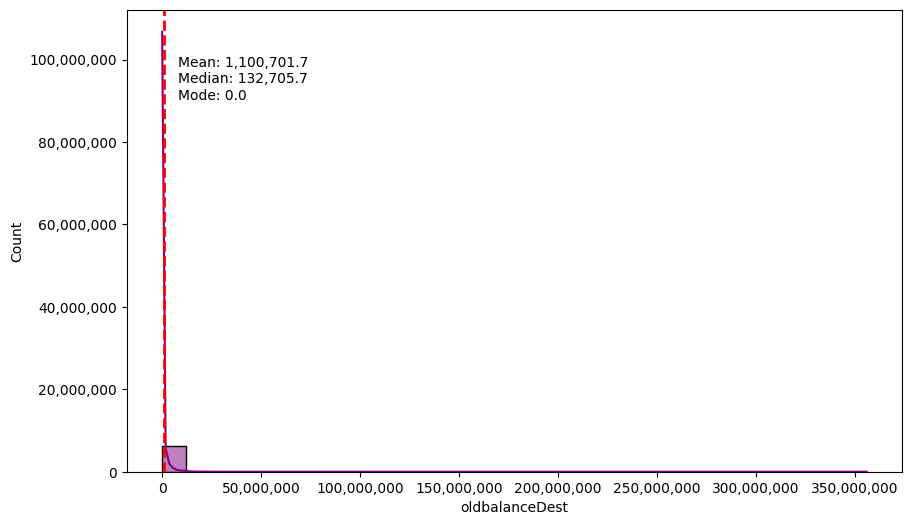

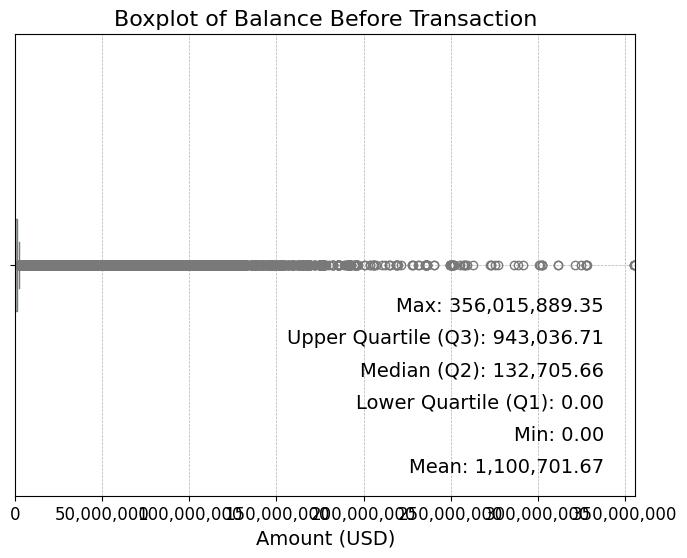

Variable: oldbalanceDest
Count of outliers: 786135
Percentage of outliers: 12.36%
Lower bound for outliers: -1414555.06
Upper bound for outliers: 2357591.77


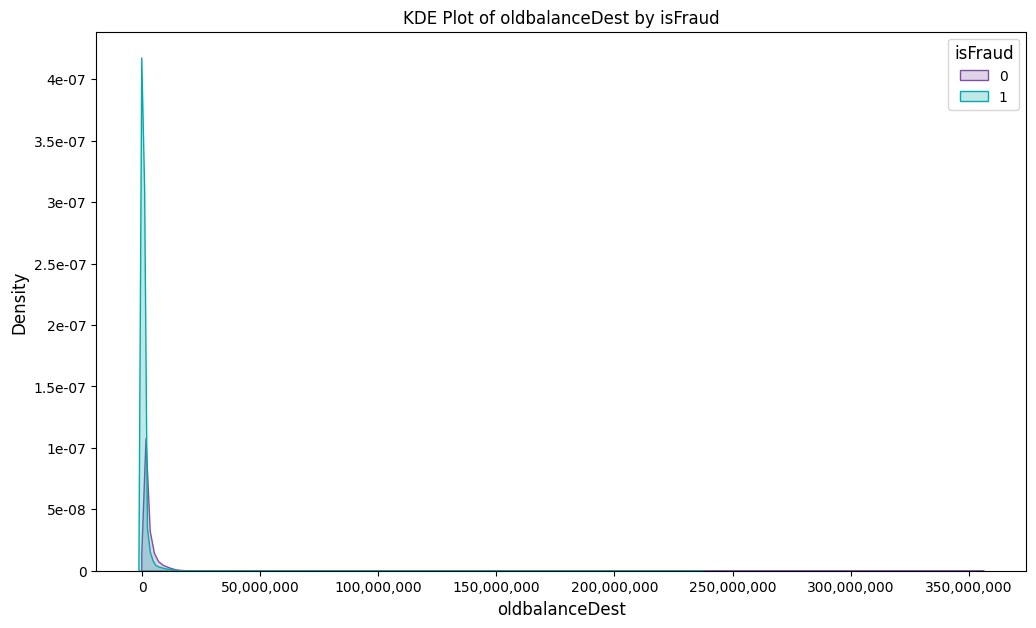

The 'isFraud' column has a total of 2 categories.


In [53]:
# Uso de plot_histogram_with_density_and_mean
visualizer.plot_histogram_with_density_and_mean('oldbalanceDest')

# Uso de custom_boxplot (adaptar parámetros según necesidad)
visualizer.custom_boxplot(variable='oldbalanceDest',
                          plot_title='Boxplot of Balance Before Transaction',
                          x_label='Amount (USD)',
                          y_label='')

# Uso de calculate_outliers
visualizer.calculate_outliers('oldbalanceDest')

# Uso de plot_multi_kde
visualizer.plot_multi_kde(numeric_column='oldbalanceDest', 
                          category_column='isFraud', 
                          axis_label_fontsize=10, 
                          axis_title_fontsize=12)

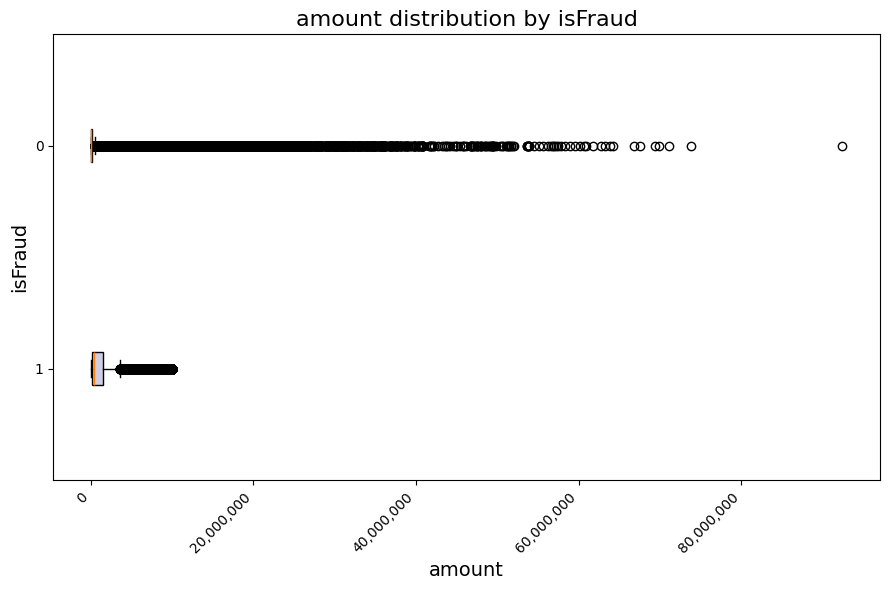

In [56]:
visualizer.plot_multiple_boxplots_matplotlib(
    col_dict={'isFraud': 'amount'}, 
)

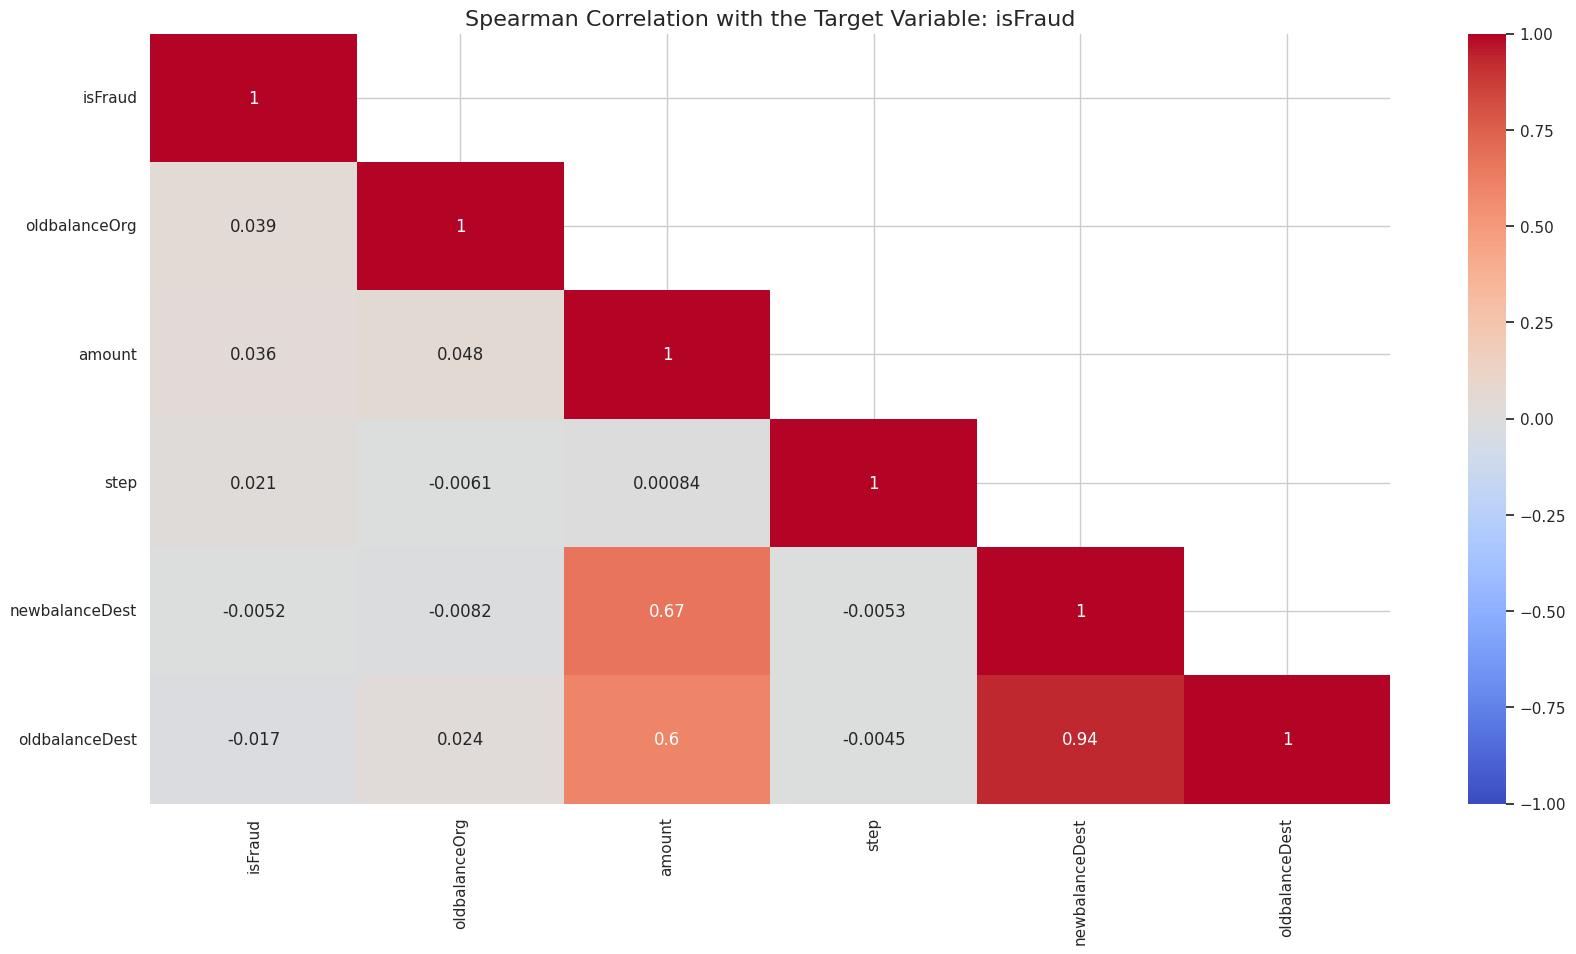

In [66]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud']


target_variable = 'isFraud'
top_x_variables = 6

df_selected_columns = df[numeric_columns]

# Calcular la matriz de correlación de Spearman
correlation_matrix = df_selected_columns .corr(method='spearman')

# Obtener las X variables con mayor correlación respecto a una variable target
top_corr_variables = correlation_matrix[target_variable].sort_values(ascending=False).head(top_x_variables).index

# Filtrar la matriz de correlación para obtener solo las variables de interés
corr_matrix_top = correlation_matrix.loc[top_corr_variables, top_corr_variables]

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.ones_like(corr_matrix_top, dtype=bool)
mask[np.tril_indices_from(mask)] = False

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.set_palette("light:#5A9")
sns.set_style("whitegrid")

# Usar la máscara en el mapa de calor
sns.heatmap(corr_matrix_top, annot=True, cmap="coolwarm", vmin=-1, vmax=1, mask=mask)

# Configurar el título del gráfico
plt.title(f"Spearman Correlation with the Target Variable: {target_variable}", fontsize=16)

# Rotar las etiquetas de los ejes para que sean legibles
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Mostrar el gráfico
plt.show()

TODO: la variable "newbalanceDest" se debe remover del dataset dado que está altamente correlacionada con "oldbalanceDest".

In [10]:
df.groupby('isFraud')['amount'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
1,8213.00,1467967.30,2404252.95,0.00,127091.33,441423.44,1517771.48,10000000.00
0,6354407.00,178197.04,596236.98,0.01,13368.40,74684.72,208364.76,92445516.64


In [68]:
df.groupby('isFraud')['oldbalanceDest'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.00,1101420.87,3399201.79,0.00,0.00,133311.80,944144.58,356015889.35
1,8213.00,544249.62,3336420.95,0.00,0.00,0.00,147828.66,236230516.82


In [67]:
df.groupby('isFraud')['oldbalanceOrg'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
1,8213.00,1649667.61,3547719.44,0.00,125822.44,438983.45,1517771.48,59585040.37
0,6354407.00,832828.71,2887144.03,0.00,0.00,14069.00,106969.50,43818855.30


In [70]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

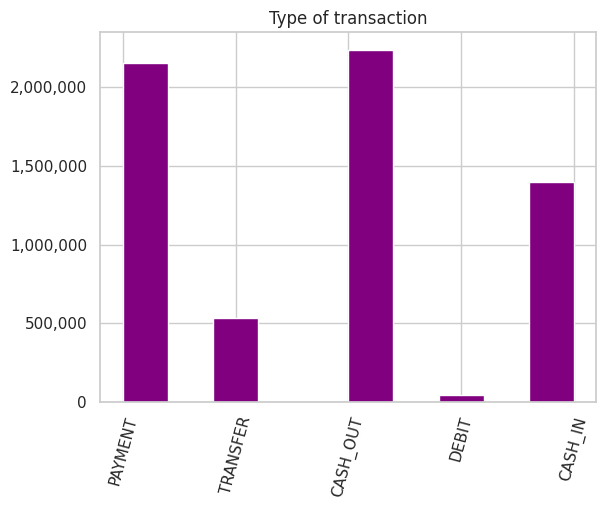

In [73]:
from matplotlib.ticker import FuncFormatter
def thousands_formatter(x, pos):
    return f'{int(x):,}'

df.type.hist(xrot=75, color='purple')
plt.title('Type of transaction')

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

In [80]:
# Interesting questions - UNIFIED TWO CATEGORICAL VARIABLES

print("Number of transactions with amount is less 0?")
print(len(df[df.amount<0]))

print("Number of transactions with amount is equal to 0?")
print(len(df[df.amount==0]))

print("What type of transactions are they?")
print(df[df.amount<=0]['type'].value_counts())


df_temp = df[df.isFlaggedFraud==1]
print("How many frauds transactions are Flagged?:")
print("\t",len(df_temp))

print("What type of transactions are they?")
print("\t",df_temp['type'].value_counts().index[0])

print("Are all these flagged also marked as Fraud Transactions?")
print("\t",df_temp['isFraud'].value_counts()[1] == len(df_temp))

Number of transactions with amount is less 0?
0
Number of transactions with amount is equal to 0?
16
What type of transactions are they?
type
CASH_OUT    16
Name: count, dtype: int64
How many frauds transactions are Flagged?:
	 16
What type of transactions are they?
	 TRANSFER
Are all these flagged also marked as Fraud Transactions?
	 True


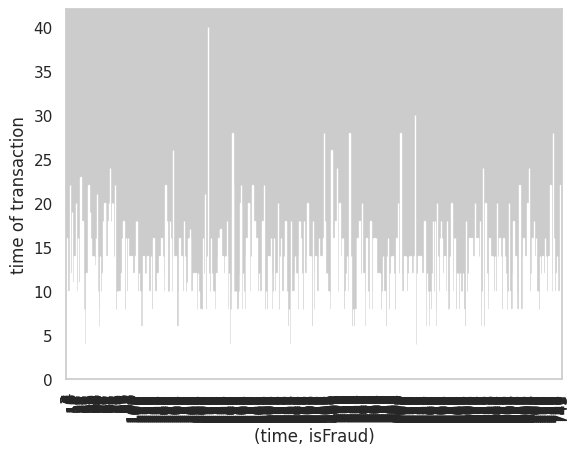

In [82]:
# Las transacciones de fraude están uniformemente distribuidas en el tiempo. 
fraud = df['isFraud'].isin([1])

fraud_time = df[fraud].groupby(['step']).size().plot(kind='bar')
fraud_time.set_xlabel("(time, isFraud)")
fraud_time.set_ylabel("time of transaction")
plt.show()

## Conclusiones

* Se tienen más de 6 millones de registros y 11 columnas, de las cuales 1 es el target.<br/>

* 5 variables son tipo float, 3 tipo int, 3 tipo object. En resumen, 8 numéricas y 3 categóricas.<br/>

* 2 de las variables categóricas son “identificadores” o nombres. Una de ellas corresponde al tipo de transacción y tiene 5 categorías.<br/>

* Disclaimer: La variable “isFlaggedFraud” creo que es un error por dos razones: 1. No la mencionan en el .txt y es contraintuitiva respecto a “isFraud”. Es interesante ver que son 16 transacciones etiquetadas como fraudulentas y cuya cifra en “amount” corresponde a 0 y su “type” corresponde a “CASH_OUT”. Por su parte, también son 16 transacciones etiquetadas como fraudulentas en la variable “isFlaggedFraud” y que son de “type = TRANSFER”. Dado lo anterior, podría simplificar estas dos categorías en una sola. También se podrían usar todas las categorías, dependerá de la aproximación que se realice. <br/>

* No hay columnas con datos nulos en el dataframe. <br/>

* Es un problema altamente desbalanceado, donde predomina la clase 0, correspondiente a transacciones no fraudulentas Por su parte, la clase 1 que corresponde a las fraudulentas representa solo un 0.13% del dataset.<br/>

* Todas las variables tienen un sesgo alto (mayor a 1). Solo la variable “step” tiene un sesgo entre -0.5 y 0.5, lo cual la hace “simétrica”. Es “normal” encontrarse con este tipo de datos, pero es fundamental tener en cuenta esto antes de modelar ya que algunos modelos pueden afectarse por esto y requieren de una transformación previa en dichas variables. <br/>

* Los datos no tienen una distribución normal. Por esto se realiza una matriz de correlación de Spearman, la cual muestra que las variables “oldbalanceDest” y “newbalanceDest” presentan un coeficiente de correlación de 0.94. La correlación de la variable objetivo con la variable “olbalanceDest” es ligeramente mayor (-0.017)  que la que tiene “newbalanceDest” con “isFraud”. Por esto, para evitar variables redundantes en el modelo, se eliminará “newbalanceDest”.<br/>

* Las transacciones más frecuentes son “CASH_OUT” y “PAYMENT”.<br/>

* Un dato particular es que se tienen 16 transacciones que cuyo monto fue igual a 0, estas son de tipo “CASH_OUT” y las 16 están marcadas como fraudulentas.<br/>

* Las transacciones de fraude están uniformemente distribuidas en el tiempo. <br/>


### Respuesta a la pregunta 1:

En general es un dataset con pocas dimensiones, con datos altamente sesgados y de varianza alta. Esto puede ser un indicio de que tienen información que permite discriminar entre clases. El análisis de correlación de Spearman muestra un coeficiente superior a 0.9 entre “oldbalanceDest” y “newbalanceDest”, lo cual permite elegir una de las dos para entrenar el modelo. <br/>

Las variables categóricas 'nameOrig' y 'nameDest' son diferentes casi que en todos los registros, lo cual complicaría usar técnicas como one hot encoding. Sin embargo, opciones como target encoding o count encoding podrían ser útiles. <br/>

En general, las variables más relevantes "a priori" para comenzar a modelar son:<br/>
* step 
* type
* amount
* oldbalanceOrg
* newbalanceOrig
* oldbalanceDest

# Question 2, 3 and 4: Modeling and Explanation

In [46]:
target = df['isFraud']
data = df[[col for col in df.columns if col not in ['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'newbalanceDest']]]

## Question 2 and 3: Model and Artifacts

In [49]:
model = FraudDetectionModel(data, target, 'logistic')


# Lista de métodos de balanceo a probar
balance_methods = ['SMOTE', 'ADASYN', 'None']

# Bucle para entrenar y registrar en MLflow usando cada método de balanceo
for balance in balance_methods:
    # Preparar los datos con el método de balance especificado
    model.prepare_data(balance=balance)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    # model.split_data()  # Asegúrate de definir esta función si la necesitas

    # Entrenar el modelo y registrar en MLflow
    model_name = f'LogisticRegression_{balance}'
    model.train_model(model_name)

    print(f"Model trained and logged with balance method: {balance}")

2024/04/16 12:41:32 INFO mlflow.tracking.fluent: Experiment with name 'Fraud_Detection_Experiment' does not exist. Creating a new experiment.


----------------------------------------
Fold: 0
Groups for training:
[461 397 208 171 343 212 333  46 394 281 656 230 282 419 443 260 257 722
 202 329 205 378 607  13 330 136 228 500 522 340 447  18 606 210 236 334
 395 404 204 371 374 574 402 209 254 570 688 326 354 213 138 280 635 160
 324  95 223 576 203 582 356  39 541 377 731 259 139 187 101 611 252 355
  66 468 396 276 358 592 164 155 401 275 350 189 490 250 235 467 372 543
 140 234 117 359 211 568 104 714 181 300 331 256  71 692 370 184 612 587
 399 332 137 241 346 616 156 310  43  93 165 589 328  17 625 166 427 302
 185 718  98 469  72 133  40 261 712 349  24  12 173 691 132 403 159 581
 695 680 162  37 306 251 528 379   8 595 503 383 161 121  45 317 632 134
 617 455  44 182 352 186 489 188 153 237 382 154 533 305 231 143 464 726
  38  64 398 175 206 130 131 215 229 192 347 279  16 183 320 301 548 178
 316 351 724 249 322 232  20  94 618 191 278 274 325  41 353 145 233 227
 614 373 527 380 217 400 258 196 163 225 431 491 702 1

/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LogisticRegression_SMOTE'.
2024/04/16 12:41:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_SMOTE, version 1
Created version '1' of mo

Average Metrics - Accuracy: 0.9345636965509847, F1: 0.9423951358106843, Precision: 0.9414709154440071, Recall: 0.9438630536541763, Log Loss: 0.183614859081422
Total training time: 6.99 seconds
Model trained and logged with balance method: SMOTE
----------------------------------------
Fold: 0
Groups for training:
[461 397 208 171 343 212 333  46 394 281 656 230 282 419 443 260 257 722
 202 329 205 378 607  13 330 136 228 500 522 340 447  18 606 210 236 334
 395 404 204 371 374 574 402 209 254 570 688 326 354 213 138 280 635 160
 324  95 223 576 203 582 356  39 541 377 731 259 139 187 101 611 252 355
  66 468 396 276 358 592 164 155 401 275 350 189 490 250 235 467 372 543
 140 234 117 359 211 568 104 714 181 300 331 256  71 692 370 184 612 587
 399 332 137 241 346 616 156 310  43  93 165 589 328  17 625 166 427 302
 185 718  98 469  72 133  40 261 712 349  24  12 173 691 132 403 159 581
 695 680 162  37 306 251 528 379   8 595 503 383 161 121  45 317 632 134
 617 455  44 182 352 186 489

/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LogisticRegression_ADASYN'.
2024/04/16 12:41:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_ADASYN, version 1
Created version '1' of 

Average Metrics - Accuracy: 0.9292035023362629, F1: 0.9293075360994592, Precision: 0.8742146981902295, Recall: 0.9968621362877238, Log Loss: 0.1871830018111233
Total training time: 6.65 seconds
Model trained and logged with balance method: ADASYN
----------------------------------------
Fold: 0
Groups for training:
[461 397 208 171 343 212 333  46 394 281 656 230 282 419 443 260 257 722
 202 329 205 378 607  13 330 136 228 500 522 340 447  18 606 210 236 334
 395 404 204 371 374 574 402 209 254 570 688 326 354 213 138 280 635 160
 324  95 223 576 203 582 356  39 541 377 731 259 139 187 101 611 252 355
  66 468 396 276 358 592 164 155 401 275 350 189 490 250 235 467 372 543
 140 234 117 359 211 568 104 714 181 300 331 256  71 692 370 184 612 587
 399 332 137 241 346 616 156 310  43  93 165 589 328  17 625 166 427 302
 185 718  98 469  72 133  40 261 712 349  24  12 173 691 132 403 159 581
 695 680 162  37 306 251 528 379   8 595 503 383 161 121  45 317 632 134
 617 455  44 182 352 186 4

/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LogisticRegression_None'.
2024/04/16 12:41:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_None, version 1


Average Metrics - Accuracy: 0.8708655660399935, F1: 0.872989638392473, Precision: 0.9860272816402093, Recall: 0.7840826629501565, Log Loss: 0.2744384337705127
Total training time: 6.19 seconds
Model trained and logged with balance method: None


Created version '1' of model 'LogisticRegression_None'.


In [51]:
model = FraudDetectionModel(data, target, 'lgbm')


# Lista de métodos de balanceo a probar
balance_methods = ['SMOTE', 'ADASYN', 'None']

# Bucle para entrenar y registrar en MLflow usando cada método de balanceo
for balance in balance_methods:
    # Preparar los datos con el método de balance especificado
    model.prepare_data(balance=balance)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    # model.split_data()  # Asegúrate de definir esta función si la necesitas

    # Entrenar el modelo y registrar en MLflow
    model_name = f'LightGBM_{balance}'
    model.train_model(model_name)

    print(f"Model trained and logged with balance method: {balance}")

----------------------------------------
Fold: 0
Groups for training:
[461 397 208 171 343 212 333  46 394 281 656 230 282 419 443 260 257 722
 202 329 205 378 607  13 330 136 228 500 522 340 447  18 606 210 236 334
 395 404 204 371 374 574 402 209 254 570 688 326 354 213 138 280 635 160
 324  95 223 576 203 582 356  39 541 377 731 259 139 187 101 611 252 355
  66 468 396 276 358 592 164 155 401 275 350 189 490 250 235 467 372 543
 140 234 117 359 211 568 104 714 181 300 331 256  71 692 370 184 612 587
 399 332 137 241 346 616 156 310  43  93 165 589 328  17 625 166 427 302
 185 718  98 469  72 133  40 261 712 349  24  12 173 691 132 403 159 581
 695 680 162  37 306 251 528 379   8 595 503 383 161 121  45 317 632 134
 617 455  44 182 352 186 489 188 153 237 382 154 533 305 231 143 464 726
  38  64 398 175 206 130 131 215 229 192 347 279  16 183 320 301 548 178
 316 351 724 249 322 232  20  94 618 191 278 274 325  41 353 145 233 227
 614 373 527 380 217 400 258 196 163 225 431 491 702 1

/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LightGBM_SMOTE'.
2024/04/16 12:42:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_SMOTE, version 1
Created version '1' of model 'LightGBM_SMOTE'

Average Metrics - Accuracy: 0.9959372430278275, F1: 0.9955672323540992, Precision: 0.9923455261618188, Recall: 0.9988175675675676, Log Loss: 0.01609867078147131
Total training time: 6.90 seconds
Model trained and logged with balance method: SMOTE
----------------------------------------
Fold: 0
Groups for training:
[461 397 208 171 343 212 333  46 394 281 656 230 282 419 443 260 257 722
 202 329 205 378 607  13 330 136 228 500 522 340 447  18 606 210 236 334
 395 404 204 371 374 574 402 209 254 570 688 326 354 213 138 280 635 160
 324  95 223 576 203 582 356  39 541 377 731 259 139 187 101 611 252 355
  66 468 396 276 358 592 164 155 401 275 350 189 490 250 235 467 372 543
 140 234 117 359 211 568 104 714 181 300 331 256  71 692 370 184 612 587
 399 332 137 241 346 616 156 310  43  93 165 589 328  17 625 166 427 302
 185 718  98 469  72 133  40 261 712 349  24  12 173 691 132 403 159 581
 695 680 162  37 306 251 528 379   8 595 503 383 161 121  45 317 632 134
 617 455  44 182 352 186 4

/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LightGBM_ADASYN'.
2024/04/16 12:42:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_ADASYN, version 1
Created version '1' of model 'LightGBM_ADAS

Average Metrics - Accuracy: 0.9911905033136547, F1: 0.9897680410863867, Precision: 0.9811499725480906, Recall: 0.9986486486486487, Log Loss: 0.024814533737087908
Total training time: 7.10 seconds
Model trained and logged with balance method: ADASYN
----------------------------------------
Fold: 0
Groups for training:
[461 397 208 171 343 212 333  46 394 281 656 230 282 419 443 260 257 722
 202 329 205 378 607  13 330 136 228 500 522 340 447  18 606 210 236 334
 395 404 204 371 374 574 402 209 254 570 688 326 354 213 138 280 635 160
 324  95 223 576 203 582 356  39 541 377 731 259 139 187 101 611 252 355
  66 468 396 276 358 592 164 155 401 275 350 189 490 250 235 467 372 543
 140 234 117 359 211 568 104 714 181 300 331 256  71 692 370 184 612 587
 399 332 137 241 346 616 156 310  43  93 165 589 328  17 625 166 427 302
 185 718  98 469  72 133  40 261 712 349  24  12 173 691 132 403 159 581
 695 680 162  37 306 251 528 379   8 595 503 383 161 121  45 317 632 134
 617 455  44 182 352 186

/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LightGBM_None'.
2024/04/16 12:43:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_None, version 1


Average Metrics - Accuracy: 0.9974061546002028, F1: 0.9970595732915605, Precision: 0.9959799720975944, Recall: 0.9981418918918918, Log Loss: 0.014031978963625468
Total training time: 6.73 seconds
Model trained and logged with balance method: None


Created version '1' of model 'LightGBM_None'.


## Question 4: Explainability

In [52]:
results = mlflow.search_runs(filter_string="metrics.average_f1_score > 0.5")

In [59]:
results.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.fold_0_log_loss,metrics.fold_1_log_loss,metrics.average_accuracy,metrics.fold_0_f1_score,metrics.fold_1_accuracy,metrics.fold_1_recall,metrics.average_log_loss,metrics.fold_0_recall,metrics.average_precision,metrics.fold_0_accuracy,metrics.fold_1_precision,metrics.average_recall,metrics.fold_0_precision,metrics.average_f1_score,metrics.fold_1_f1_score,params.total_training_time,params.model_name,params.balance_method,params.n_splits,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type
0,f857bd28745c4b219707334d07b628dd,1,FINISHED,/mnt/d/fraud_detection_test/mlflow-artifacts/1...,2024-04-16 17:42:54.933000+00:00,2024-04-16 17:43:01.499000+00:00,0.02,0.01,1.00,0.99,1.00,1.00,0.01,1.00,1.00,1.00,1.00,1.00,0.99,1.00,1.00,3.0494794845581055,LightGBM_None,None,2,"[{""run_id"": ""f857bd28745c4b219707334d07b628dd""...",dpalacio,/home/dpalacio/miniconda3/envs/fraud_detection...,treasured-chimp-417,LOCAL
1,86850e0f458241ac9737160cde4804f3,1,FINISHED,/mnt/d/fraud_detection_test/mlflow-artifacts/1...,2024-04-16 17:42:47.848000+00:00,2024-04-16 17:42:54.769000+00:00,0.04,0.01,0.99,0.98,1.00,1.00,0.02,1.00,0.98,0.98,1.00,1.00,0.97,0.99,1.00,3.284982681274414,LightGBM_ADASYN,ADASYN,2,"[{""run_id"": ""86850e0f458241ac9737160cde4804f3""...",dpalacio,/home/dpalacio/miniconda3/envs/fraud_detection...,unequaled-lamb-338,LOCAL
2,72932fe1d60040328f0712ac89ee9754,1,FINISHED,/mnt/d/fraud_detection_test/mlflow-artifacts/1...,2024-04-16 17:42:40.954000+00:00,2024-04-16 17:42:47.668000+00:00,0.02,0.01,1.00,0.99,1.00,1.00,0.02,1.00,0.99,0.99,1.00,1.00,0.99,1.00,1.00,3.1365840435028076,LightGBM_SMOTE,SMOTE,2,"[{""run_id"": ""72932fe1d60040328f0712ac89ee9754""...",dpalacio,/home/dpalacio/miniconda3/envs/fraud_detection...,skittish-shoat-725,LOCAL
3,1101e5462fb34f0db67cc01f252c5142,1,FINISHED,/mnt/d/fraud_detection_test/mlflow-artifacts/1...,2024-04-16 17:41:46.160000+00:00,2024-04-16 17:41:52.167000+00:00,0.23,0.32,0.87,0.85,0.85,0.83,0.27,0.74,0.99,0.89,0.99,0.78,0.98,0.87,0.90,2.7802486419677734,LogisticRegression_None,None,2,"[{""run_id"": ""1101e5462fb34f0db67cc01f252c5142""...",dpalacio,/home/dpalacio/miniconda3/envs/fraud_detection...,omniscient-mare-706,LOCAL
4,8625d011dfe84a59932819cff8a94630,1,FINISHED,/mnt/d/fraud_detection_test/mlflow-artifacts/1...,2024-04-16 17:41:39.502000+00:00,2024-04-16 17:41:45.984000+00:00,0.24,0.14,0.93,0.88,0.97,1.00,0.19,0.99,0.87,0.89,0.96,1.00,0.79,0.93,0.98,3.175657272338867,LogisticRegression_ADASYN,ADASYN,2,"[{""run_id"": ""8625d011dfe84a59932819cff8a94630""...",dpalacio,/home/dpalacio/miniconda3/envs/fraud_detection...,orderly-bass-21,LOCAL


In [60]:
## Summary results

results[['params.model_name','run_id', 'experiment_id','status', 'metrics.average_f1_score','metrics.average_recall', 'metrics.average_accuracy', 'metrics.average_log_loss', 
'metrics.average_precision']]

,params.model_name,run_id,experiment_id,status,metrics.average_f1_score,metrics.average_recall,metrics.average_accuracy,metrics.average_log_loss,metrics.average_precision
0,LightGBM_None,f857bd28745c4b219707334d07b628dd,1,FINISHED,1.00,1.00,1.00,0.01,1.00
1,LightGBM_ADASYN,86850e0f458241ac9737160cde4804f3,1,FINISHED,0.99,1.00,0.99,0.02,0.98
2,LightGBM_SMOTE,72932fe1d60040328f0712ac89ee9754,1,FINISHED,1.00,1.00,1.00,0.02,0.99
3,LogisticRegression_None,1101e5462fb34f0db67cc01f252c5142,1,FINISHED,0.87,0.78,0.87,0.27,0.99
4,LogisticRegression_ADASYN,8625d011dfe84a59932819cff8a94630,1,FINISHED,0.93,1.00,0.93,0.19,0.87
5,LogisticRegression_SMOTE,52aacad761cc4d7e99f9ca5cf4ea9c51,1,FINISHED,0.94,0.94,0.93,0.18,0.94


In [58]:
model.model['classifier'].feature_importances_ 

array([478, 898, 909, 141, 304,  22,  36,  18,  85, 109], dtype=int32)

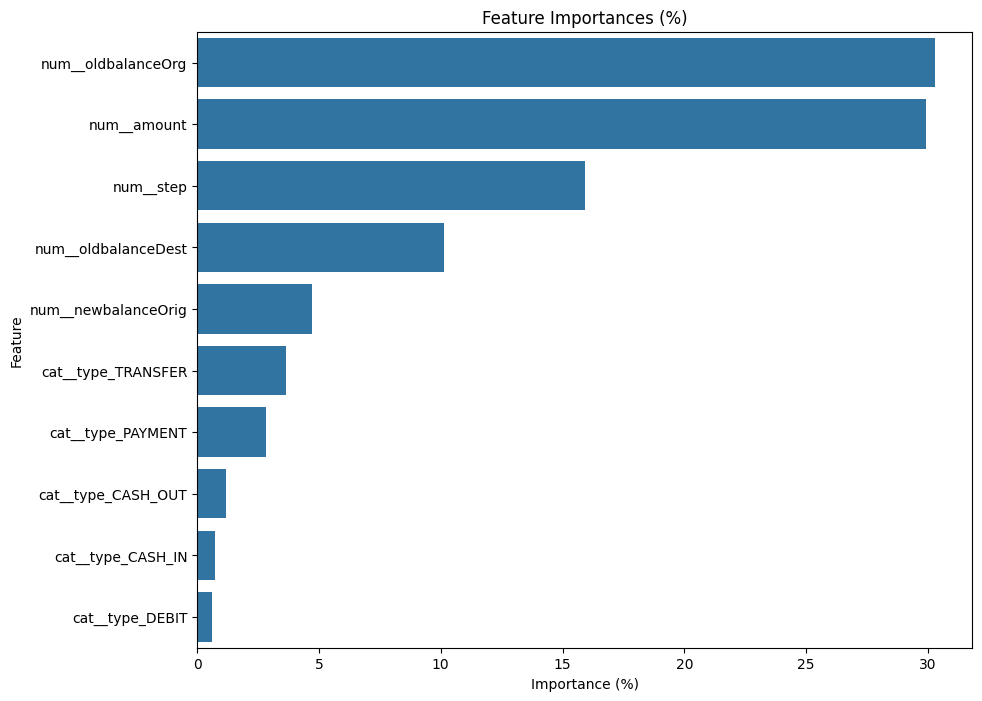

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

if 'preprocessor' in model.model.named_steps:
    preprocessor = model.model.named_steps['preprocessor']
    classifier = model.model.named_steps['classifier']

    # Obtener los nombres de las columnas procesadas
    feature_names = preprocessor.get_feature_names_out()

    # Importancias de las características del modelo
    importances = classifier.feature_importances_

    # Calcular la importancia en porcentajes
    importances_percentage = 100 * (importances / importances.sum())

    # Crear DataFrame con las características y sus importancias
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'importance_percentage': importances_percentage
    })

    # Ordenar el DataFrame por importancia para una mejor visualización
    feature_importances.sort_values(by='importance_percentage', ascending=False, inplace=True)

    # Visualizar las importancias de las características en porcentajes
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance_percentage', y='feature', data=feature_importances)
    plt.title('Feature Importances (%)')
    plt.xlabel('Importance (%)')
    plt.ylabel('Feature')
    plt.show()
else:
    print("No se encontró el preprocesador o el clasificador en el pipeline.")


/home/dpalacio/miniconda3/envs/fraud_detection/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


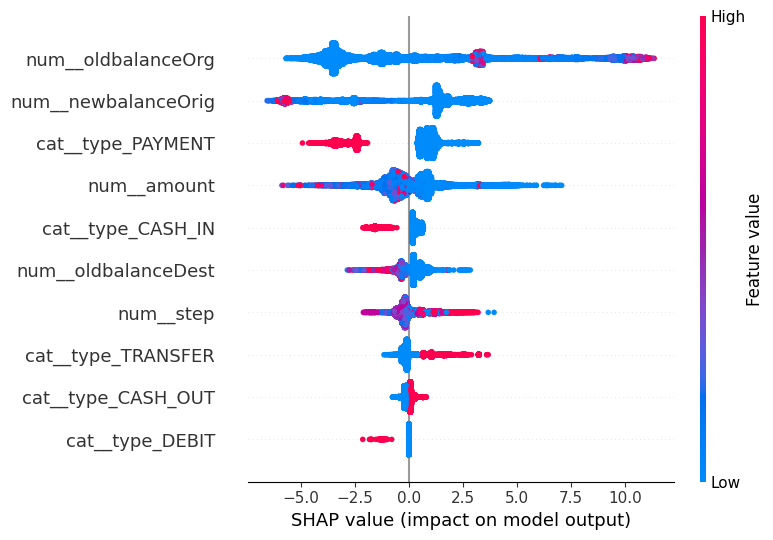

In [63]:
if 'preprocessor' in model.model.named_steps and 'classifier' in model.model.named_steps:
    # Crea un explainer con el modelo
    explainer = shap.TreeExplainer(model.model.named_steps['classifier'])

    # Usamos el preprocesador para transformar los datos, lo cual es necesario para obtener los valores correctos
    X_transformed = model.model.named_steps['preprocessor'].transform(model.data)

    # Calcula los SHAP values
    shap_values = explainer.shap_values(X_transformed)

    # Asegúrate de que shap_values es una lista (común con modelos multiclase), si es así, elige el set de SHAP values para la clase de interés
    # Por ejemplo, shap_values[1] para la clase positiva en una clasificación binaria
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Ajusta esto según la clase de interés

    # Visualizar la importancia de las características con un summary plot
    shap.summary_plot(shap_values, X_transformed, feature_names=model.model.named_steps['preprocessor'].get_feature_names_out())
else:
    print("Modelo o pipeline no configurado correctamente.")


El modelo con mejor desempeño de acuerdo a las métricas de f1_score y recall fue LightGBM_None. Este modelo tiene la etapa de preprocesamiento que es común en todos, pero no tiene ningún método de sampling. Es decir, son los datos con su mayor % de desbalance. Sin embargo, las métricas de todos los modelos están relativamente altas. Esto no significa que el procedimiento realizado garantiza que el modelo está en capacidad de detectar cuando una transacción es fraudulenta. Lo que se debe realizar es una exploración más exhaustiva para calibrar parámetros, aumentar los fold de la validación cruzada.<br/>

Es importante resaltar que el cross validation llevado a cabo en este notebook respecta el orden cronológico de los registros. Es importante tener esto en cuenta, ya que una cross validation tradicional podría introducir datos futuros en la etapa de entrenamiento.
Las mejores variables predictoras tienen que ver con el dinero de la transacción (amount) y el dinero que se tenía antes de la transacción (oldbalanceOrg). Dado el desempeño prematuro del modelo y que aún se puede mejorar con algunas técnicas, es posible que la interpretabilidad pueda cambiar un poco en próximas iteraciones. Sin embargo, los resultados apuntas a que el tipo de movimiento bancario no es tan relevante para este caso de estudio. En este tipo de estudios de caso es interesante segmentar los datos por franjas horarios para identificar patrones entre as variables objetivo y las predictoras. Podría ser una extensión de este problema buscar más variables que puedan aumentar la capacidad de discriminación del modelo.<br/>

**Oportunidades de mejora:**

•	Probar con diferentes proporciones de la clase mayoritaria y ajustar los hiperparámetros que maximicen el F1 score, ya que esta métrica “promedia” la precisión y el recall. De hecho, para un modelo más conservador, debería de maximizarse es el recall.

•	Los métodos de balanceo Oversampling y Undersampling son útiles (SMOTE y ADASYN) pero cuando los problemas son tan desbalanceados, el feature engineering es fundamental para enriquecer más la información, aunque el incremento de las métricas sea despreciable. Es una definición de negocio y del problema objeto de estudio qué tanto se podrían “crear” reglas para que cuando se creen muestras aleatorias de la clase minoritaria, además de tratar de asemejarse a la distribución original de los datos, deben cumplir con comportamientos característicos del fenómeno que representan.

•	Los modelos basados en árboles tienden a generalizar mejor en este tipo de situaciones, pero el esfuerzo debe centrarse en la búsqueda de los parámetros que mejoran la métrica en cuestión. En este caso, es fundamental concentrarse en los verdaderos positivos para atacar los fraudes.

•	“Iterar” con más transformaciones sobre las variables numéricas, por ejemplo: PowerTransform y sobre las categóricas: target encoding.


# Question 6

In [66]:
# Para abrir un puerto con MLFlow ejecutar esto en la terminal:

# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlflow-artifacts --host 0.0.0.0

Este código implementa un flujo de trabajo básico para un sistema de detección de fraudes utilizando un modelo de aprendizaje automático. El proceso incluye cargar un conjunto de datos, procesar estos datos, entrenar un modelo, hacer predicciones con el modelo, cargar un modelo entrenado desde MLflow, y hacer nuevas predicciones.

In [ ]:
import sys 
sys.path.append("../src")
from pipeline import FraudDetectionModel
import pandas as pd

# Cargar el conjunto de datos
data = pd.read_csv(r"/mnt/d/fraud_detection_test/data/fraud_detection.csv")

# Definir la columna objetivo y las columnas de características
target = df['isFraud']
data = df[[col for col in df.columns if col not in ['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'newbalanceDest']]]

model = FraudDetectionModel(data, target,'lgbm')

# Preparar los datos (incluyendo la conversión de categorías a one-hot encoding)
model.prepare_data()

# Dividir los datos y entrenar
model.train_model('LGBM_model')

# Suponiendo que quieres hacer predicciones con el modelo recién entrenado
predictions = model.predict(model.X_test)

# Imprimir las predicciones
print(predictions)

# Si deseas cargar el modelo desde MLflow y usarlo para hacer predicciones
trained_model = model.load_model("LGBM_model")
new_predictions = trained_model.predict(model.X_test)
print(new_predictions)

In [ ]:
# Transformar las probabilidades en una escala de 0 a 100
scaled_probabilities = predictions * 100
print(scaled_probabilities)


# Para obtener unas probabilidades calibradas a paritr de la predicción se podría usar:
# from sklearn.calibration import CalibratedClassifierCV